In [1]:
import pandas as pd
import pyarrow.dataset as ds
import os, psutil
import pickle
import numpy as np
import astropy.units as u
import dask.dataframe as dd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, match_coordinates_sky
from afw_utils import run_lsst_pipe_single,run_lsst_pipe_multi
from utils import get_wcs
import galsim
from astropy.visualization import ImageNormalize, AsinhStretch, ManualInterval, PercentileInterval
from astropy.table import hstack
from scipy.spatial import cKDTree
process = psutil.Process(os.getpid())

In [2]:
from main import SimCatVal
from sim import make_sim
import numpy as np
from utils import sample_position, sample_diff_position
import pickle

ind = 667
skycat_path="/hildafs/home/pladuca/main/skyCatalog.yaml"
Dp1_sample="/hildafs/home/pladuca/main/lsst-sim-package/LSST-SimCatVal/LSST-SimCatVal/pickles/ECDFS_3000_psf.pkl"
im_size=900
save_path="/hildafs/home/pladuca/main/lsst-sim-package/LSST-SimCatVal/LSST-SimCatVal/outputs_vdiff"
diff_path="/hildafs/home/pladuca/main/lsst-sim-package/LSST-SimCatVal/LSST-SimCatVal/diffsky_1_28"

with open(Dp1_sample, 'rb') as f:
    rsp_sample = pickle.load(f)

position = sample_position(1001, 223)
ra = position[ind-1][0]
dec = position[ind-1][1]
sample = rsp_sample[ind-1].copy()
sample.pop('ra')
sample.pop('dec')

diff_position = sample_diff_position(1001, 223, diff_path)
diff_ra = diff_position[ind-1][0]
diff_dec = diff_position[ind-1][1]
samp = {'i':sample['i']}

afw_dic, truths, npy_dic = make_sim(skycat_path, ra, dec, 900, 50, sample, 31.4, ind, diff_path, diff_ra, diff_dec, n_jobs=6)
cats_f = run_lsst_pipe_multi([b for b in sample.keys()], [afw_dic[i] for i in sample.keys()], 6)

2026-02-17 13:14:15,586 - INFO - Catalog data will be read from /hildafs/home/pladuca/main/roman_rubin_cats_v1.1.2_faint/roman_rubin_cats_v1.1.2_faint/
2026-02-17 13:14:18,637 - WARNING - In SkyCatalog.get_object_type_by_hp, healpix 10180  intersects region but has no data file for diffsky_galaxy
2026-02-17 13:14:18,638 - INFO - Working on healpix pixel 10307
2026-02-17 13:14:22,326 - WARNING - In SkyCatalog.get_object_type_by_hp, healpix 10308  intersects region but has no data file for diffsky_galaxy
2026-02-17 13:14:22,328 - WARNING - In SkyCatalog.get_object_type_by_hp, healpix 10180  intersects region but has no data file for star
2026-02-17 13:14:22,328 - INFO - Working on healpix pixel 10307
2026-02-17 13:14:22,367 - WARNING - In SkyCatalog.get_object_type_by_hp, healpix 10308  intersects region but has no data file for star


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/9367 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth


  0%|          | 0/9367 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth


  0%|          | 0/9367 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth


  0%|          | 0/9367 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth


  0%|          | 0/9367 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth


  0%|          | 0/9367 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth
Starting Detections
Starting Scarlet Deblend
Deblended 576 sources
Starting Measurements (parallel with 6 jobs)
Measuring band r
Measuring band u
Measuring band g
Measuring band i
Measuring band y
Measuring band z
Starting band r
Measuring 576/576 sources (removed 0 large footprints)
Starting band u
Measuring 576/576 sources (removed 0 large footprints)
Starting band g
Measuring 576/576 sources (removed 0 large footprints)
Starting band i
Measuring 576/576 sources (removed 0 large footprints)
Starting band y
Measuring 576/576 sources (removed 0 large footprints)
Starting band z
Measuring 576/576 sources (removed 0 large footprints)
Finished band y
Finished band i
Finished band z
Finished band g
Finished band u
Finished band r
Measurements complete


In [3]:
for b in 'ugrizy':
    print(len(truths[b]))

3755
3661
3645
3644
3651
3657


In [4]:
for b in 'ugrizy':
    print(np.sum(truths[b]['in_img'] == True))

3122
3122
3122
3122
3122
3122


In [127]:
truths_i = truths['i']
t_mags = -2.5*np.log10(truths_i['flux']) + 31.4
cats_i = cats_f['i']
temp = cats_i

base_cuts = ((temp['deblend_nChild'] == 0) &
    (temp['base_SdssShape_flag'] == False) &
    (temp['modelfit_CModel_instFlux'] >= 0) &
    (temp['modelfit_CModel_flag'] == False) &
    (temp['base_SdssCentroid_flag'] == False))
snr_cut = (temp['base_PsfFlux_instFlux']/temp['base_PsfFlux_instFluxErr'] >= 10)
mags = -2.5 * np.log10(temp['modelfit_CModel_instFlux']) + 31.4
mag_lim = np.percentile(mags[base_cuts], 95) + 1
truths_i = truths_i[t_mags < mag_lim]

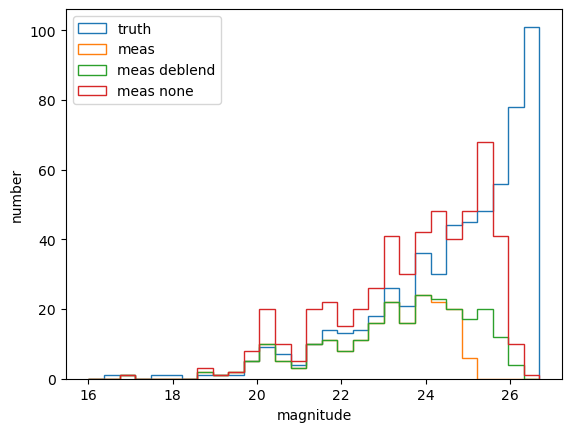

In [128]:
bins = np.linspace(16,mag_lim,30)
plt.hist(t_mags[t_mags < mag_lim][truths_i['in_img'] == True], bins,histtype="step",label='truth')
plt.hist(mags[base_cuts & snr_cut], bins,histtype="step",label='meas')
# plt.hist(mags[base_cuts], bins,histtype="step",label='meas base only')
# plt.hist(mags[snr_cut], bins,histtype="step",label='meas snr only')
plt.hist(mags[(cats_i['deblend_nChild'] == 0)&
              (cats_i['base_SdssCentroid_flag'] == False)&
              (cats_i['base_SdssShape_flag'] == False) &
              (cats_i['modelfit_CModel_instFlux'] >= 0) &
              (cats_i['modelfit_CModel_flag'] == False)
              ], bins,histtype="step",label='meas deblend')
plt.hist(mags, bins,histtype="step",label='meas none')
# plt.axvline(24.75)
plt.xlabel('magnitude')
plt.ylabel('number')
plt.legend()
plt.show()

In [87]:
# pointing = galsim.CelestialCoord(ra=ra * galsim.degrees,dec=dec * galsim.degrees)
# diff_pointing = galsim.CelestialCoord(ra=diff_ra * galsim.degrees,dec=diff_dec * galsim.degrees)
# wcs = get_wcs(900, pointing)

# true_points = []
# for i in range(len(truths_i)):
#     coord = galsim.CelestialCoord(
#         ra=truths_i['ra'][i] * galsim.degrees, #.value * galsim.degrees,
#         dec=truths_i['dec'][i] * galsim.degrees #.value * galsim.degrees,
#     )
#     u_, v_ = diff_pointing.project(coord)
#     dx = u_.deg * 3600
#     dy = v_.deg * 3600

#     world_pos = pointing.deproject(dx * galsim.arcsec, dy * galsim.arcsec,)
#     image_pos = wcs.toImage(world_pos)
#     true_points.append([image_pos.x,image_pos.y])
# true_points = np.array(true_points)

In [ ]:
# pointing = galsim.CelestialCoord(ra=ra * galsim.degrees,dec=dec * galsim.degrees)
# diff_pointing = galsim.CelestialCoord(ra=diff_ra * galsim.degrees,dec=diff_dec * galsim.degrees)
# wcs = get_wcs(900, pointing)

# true_stars = []
# for i in range(len(truths_star)):
#     coord = galsim.CelestialCoord(
#         ra=truths_star['ra'][i] * galsim.degrees, #.value * galsim.degrees,
#         dec=truths_star['dec'][i] * galsim.degrees #.value * galsim.degrees,
#     )
#     u_, v_ = pointing.project(coord)
#     dx = u_.deg * 3600
#     dy = v_.deg * 3600

#     world_pos = pointing.deproject(dx * galsim.arcsec, dy * galsim.arcsec,)
#     image_pos = wcs.toImage(world_pos)
#     true_stars.append([image_pos.x,image_pos.y])
# true_stars = np.array(true_stars)

In [ ]:
# truths_i['x'] = true_points[:,0]
# truths_i['y'] = true_points[:,1]
# truths_star['x'] = true_stars[:,0]
# truths_star['y'] = true_stars[:,1]

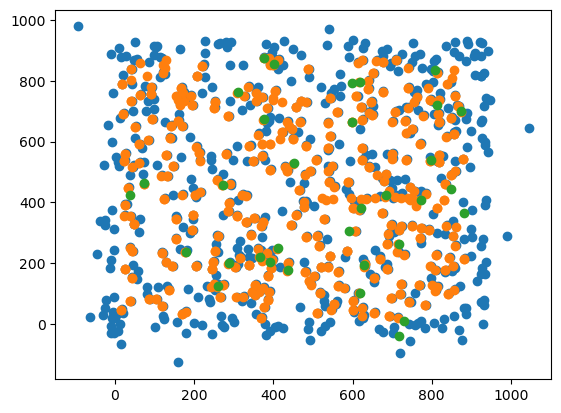

In [37]:
plt.scatter(truths_i['x'],truths_i['y'])
plt.scatter(temp['base_SdssCentroid_x'],temp['base_SdssCentroid_y'])
plt.scatter(truths_star['x'],truths_star['y'])

In [129]:
out_mask = (truths_i['x'] >= 0) & (truths_i['x'] <= 900) & (truths_i['y'] >= 0) & (truths_i['y'] <= 900)
print(np.sum(out_mask))
# out_mask = (truths_i['x'] >= 15) & (truths_i['x'] <= 885) & (truths_i['y'] >= 15) & (truths_i['y'] <= 885)
out_mask = (truths_i['x'] >= 25) & (truths_i['x'] <= 875) & (truths_i['y'] >= 25) & (truths_i['y'] <= 875)
print(np.sum(out_mask))

587
523


In [130]:
print(np.sum(out_mask)/len(out_mask) * 100)

73.87005649717514


In [131]:
(900 - 50)**2 / (900**2)

0.8919753086419753

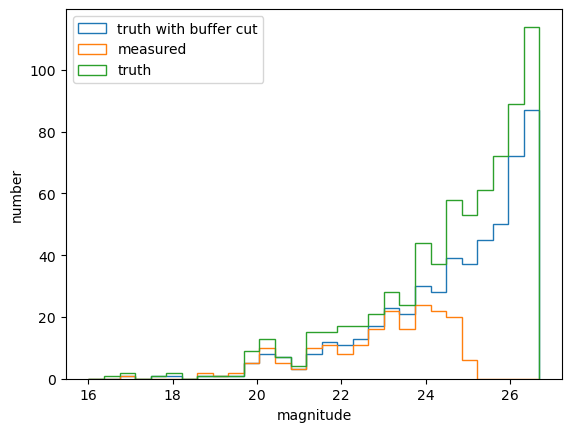

In [152]:
bins = np.linspace(16,mag_lim,30)
plt.hist(t_mags[t_mags<mag_lim][out_mask], bins,histtype="step",label='truth with buffer cut')
plt.hist(mags[base_cuts & snr_cut], bins,histtype="step",label='measured')
plt.hist(t_mags[t_mags<mag_lim], bins,histtype="step",label='truth')
# plt.axvline(24.75)
plt.xlabel('magnitude')
plt.ylabel('number')
plt.legend()
# plt.yscale('log')
plt.show()

In [133]:
ob_pix = np.column_stack([temp[base_cuts & snr_cut]['base_SdssCentroid_x'],temp[base_cuts & snr_cut]['base_SdssCentroid_y']])
true_pix = np.column_stack([truths_i['x'],truths_i['y']])
tree = cKDTree(true_pix)

dist, idx = tree.query(ob_pix, k=1)

dist = np.array(dist)
idx = np.array(idx)
sep_mask = dist < 5
ob_matches = temp[base_cuts & snr_cut][sep_mask]
ob_fails = temp[base_cuts & snr_cut][~(sep_mask)]
truth_matches = truths_i[idx[sep_mask]]
truth_fails = truths_i[idx[~sep_mask]]

x lims
23.57791575342022 872.6107857904123
y lims
32.494655374143264 870.4313845271149


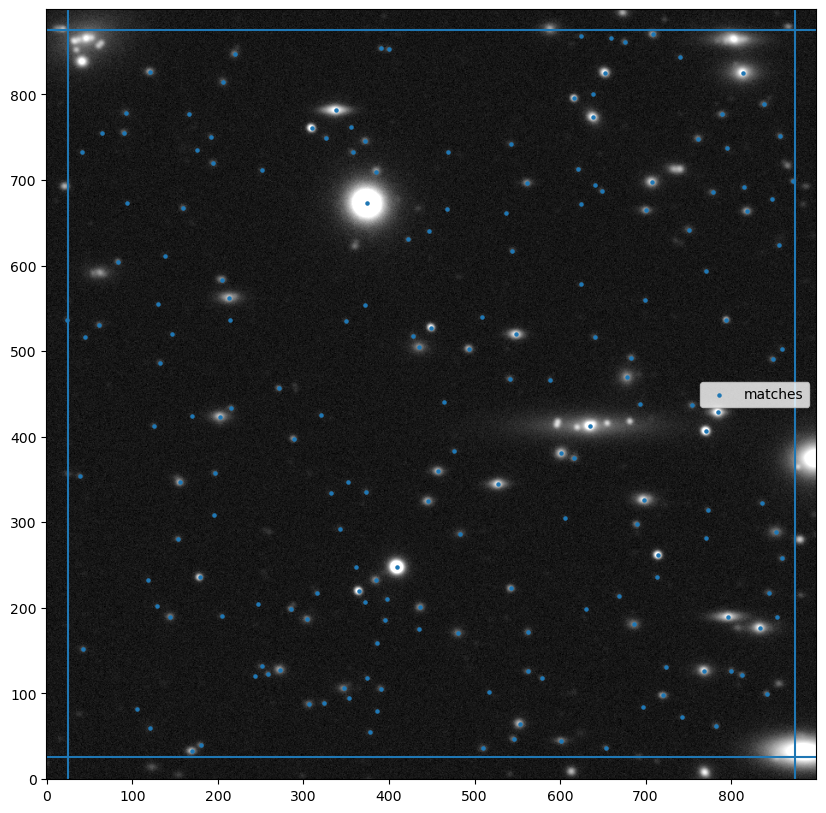

In [140]:
stretch = AsinhStretch(0.0001)
norm = ImageNormalize(
    npy_dic['i']['afw_image'].image.array,
    interval=PercentileInterval(99.5),  # clip extremes
    stretch=AsinhStretch())
fig = plt.figure(figsize=(10,10))
plt.imshow(npy_dic['i']['afw_image'].image.array, norm=norm, origin='lower', cmap='gray')
plt.scatter(ob_matches['base_SdssCentroid_x'],ob_matches['base_SdssCentroid_y'],label='matches', s=5)
# plt.scatter(ob_fails['base_SdssCentroid_x'],ob_fails['base_SdssCentroid_y'],label='ob_fails', s=5)
# plt.scatter(star_matches['base_SdssCentroid_x'],star_matches['base_SdssCentroid_y'],label='ob_fails', s=1)
# plt.scatter(truths_i[out_mask]['x'],truths_i[out_mask]['y'],label='truth_fails',s=5)
# plt.axvline(900, color='r', linestyle='--')
# plt.axhline(900, color='r', linestyle='--')
# plt.axhline(0, color='r', linestyle='--')
plt.legend()
print('x lims')
print(np.min(ob_matches['base_SdssCentroid_x']),np.max(ob_matches['base_SdssCentroid_x']))
print('y lims')
print(np.min(ob_matches['base_SdssCentroid_y']),np.max(ob_matches['base_SdssCentroid_y']))
plt.axhline(875)
plt.axhline(25)
plt.axvline(25)
plt.axvline(875)
plt.show()


In [141]:
print(np.sum(sep_mask)/ len(sep_mask) * 100)

97.95918367346938


0.9739583333333334
-0.03761755414681236
0.19566127338231015


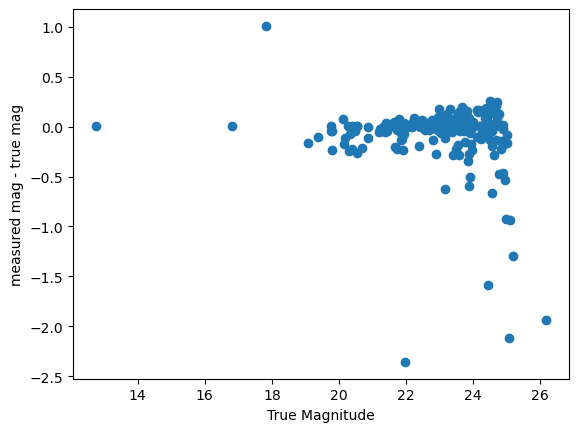

In [148]:
match_mag = -2.5 * np.log10(ob_matches['modelfit_CModel_instFlux']) + 31.4
t_match_mag = -2.5 * np.log10(truth_matches['flux']) + 31.4
d_mag = (match_mag) - (t_match_mag)

plt.scatter(t_match_mag, d_mag)
plt.xlabel('True Magnitude')
plt.ylabel('measured mag - true mag')
check = ob_matches[(d_mag <= -1) | (d_mag >= 1)]
print(np.sum(d_mag > -1)/len(d_mag))
print(np.mean(d_mag[d_mag > -1]))
print(np.std(d_mag[d_mag > -1]))

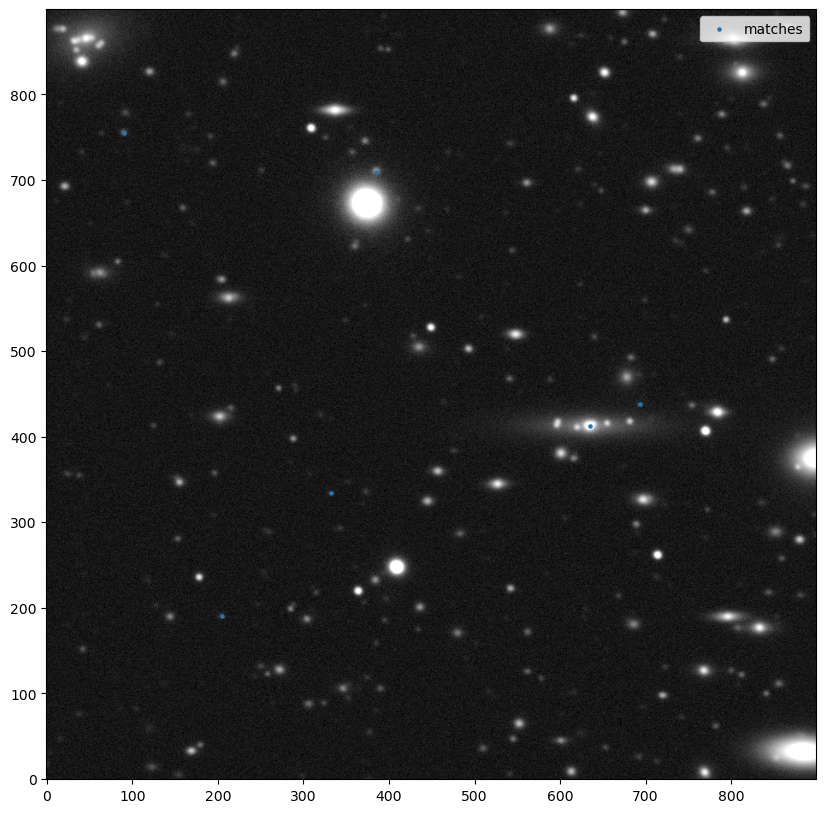

In [149]:
fig = plt.figure(figsize=(10,10))
plt.imshow(npy_dic['i']['afw_image'].image.array, norm=norm, origin='lower', cmap='gray')
plt.scatter(check['base_SdssCentroid_x'],check['base_SdssCentroid_y'],label='matches', s=5)
plt.legend()
plt.show()